# Machine Learning Engineer Nanodegree
## Capstone Project: Segmentation of Credit Card Holders

James Wanderi Kinyanjui
July 29, 2019

---

The project is based on the [proposal](https://github.com/wanderijames/credit-card-customer/blob/master/proposal.pdf) submitted for this Nanodegree program.

We will be using the [Kaggle data](https://www.kaggle.com/arjunbhasin2013/ccdata) for this project. Our goal is to create clusters of the card holders using unsupervised learning technique and then used supervised learning in assigning groups to new card holders.

# Load data

In [1]:
# Import libraries necessary for this project
import random
import warnings
from IPython.display import display # Allows the use of display() for DataFrames
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer


from feature_relevance import cc_feature_relevance
import outliers as otl
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Reproduce random-ability
random.seed(0)

# Ignore warnings
warnings.simplefilter("ignore")

try:
    raw_data = pd.read_csv("ccdata.zip")
    raw_data_rows, raw_data_columns = raw_data.shape
    print("Our dataset has {} samples with {} features each.".format(raw_data_rows, raw_data_columns))
except Exception as err:
    print("Dataset could not be loaded. Is the dataset missing? {}".format(err))

Our dataset has 8950 samples with 18 features each.


# Data Exploration

In this section we are going to undertstand our dataset.

Specifically, we will find which features are important to finding our solution to the problem.

---

In [2]:
# Display a description of the dataset
display(raw_data.describe())

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

Note how some features' standard deviation are greater than the mean, e.g BALANCE, PURCHASES

This clearly shows how the data varies and may create very distinct set of clusters.

The clusters could present the **high-income-earners**, **middle-income-earners** and **low-income-earners**.

--

## Selecting Samples

Lets select few data that we use to track some transformations that will be carried throughout our solution.

--

In [3]:
np.random.seed(1485756873)
sample_indices = sorted(np.random.choice(raw_data_rows, 5, replace=False).tolist())[:3]
print("Our selected samples indeces are:\n\n ", sample_indices)

# Create a DataFrame
samples = pd.DataFrame(raw_data.loc[sample_indices], columns = raw_data.keys()).reset_index(drop = True)
print("\nChosen samples transaction dataset:")
display(samples)

Our selected samples indeces are:

  [275, 5424, 5533]

Chosen samples transaction dataset:


CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10286     2.564117           0.181818      47.95             47.95   
1  C15577  1039.256129           1.000000     618.75              0.00   
2  C15689    30.395073           1.000000     512.47            512.47   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    0.00           0.0             0.083333   
1                  618.75           0.0             0.916667   
2                    0.00           0.0             1.000000   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.083333                          0.000000   
1                    0.000000                          0.916667   
2                    1.000000                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                     0.0                 0              1        1500.0   
1                     0.0                 0             11        1700.0   
2                     0.0                 0             12        7000.0   

     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0  294.507498         86.245988               0.0      12  
1  202.137436        262.204840               0.0      12  
2  484.669932        192.908611               1.0      12

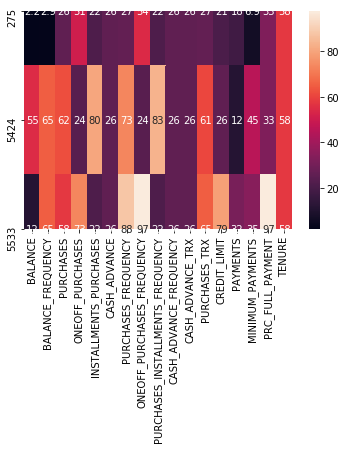

In [4]:
raw_data_without_id = raw_data.copy()
raw_data_without_id.drop(["CUST_ID"], axis=1, inplace=True)

percentiles_data = 100 * raw_data_without_id.rank(pct=True)
percentiles_samples = percentiles_data.iloc[sample_indices]
sns.heatmap(percentiles_samples, annot=True)

Generally, our sample customers do not pay cash in advance for their purchases.

**Sample 275**

Spends very little and doesn't have much balance in their card maybe due to lower credit limit. This customer could be categrorized as low-income-earner.

**Sample 5524**

This customer is a big spender with low credit limit. The customer has high balance available for spending because he/she prefers purchases in installments and regularly repays the credit issues in installments as well. So this customer can be categorized as middle-income-earner

**Sample 5533**

This customer is not a big spender but can be categorized as high-income-earner. The customer doesn't purchase in installments and regularly pays back the card issuer. This customer has very high credit limit due to their ability to repay the credit. Often than not, the bank gives high credit limit when one can show high source of income or asset value

## Feature Relevance

We will try to identify which features are relevant.

We will start by prediciting a feature using other features. The prediction score, R2, will inform us about the feature importance.

--

In [5]:
# Calculate feature-feature relavance
feature_df = cc_feature_relevance(raw_data)

In [6]:
# See feature-feature relavance
feature_df.sort_values(by="_score", ascending=False)

_predicted_feature    _score   BALANCE  BALANCE_FREQUENCY  \
6                PURCHASES_FREQUENCY  0.991076  0.000664           0.000543   
2                          PURCHASES  0.973449  0.001652           0.001118   
8   PURCHASES_INSTALLMENTS_FREQUENCY  0.964335  0.002534           0.000258   
3                   ONEOFF_PURCHASES  0.958696  0.004510           0.000063   
0                            BALANCE  0.929095  0.000000           0.009159   
7         ONEOFF_PURCHASES_FREQUENCY  0.905090  0.009500           0.000836   
4             INSTALLMENTS_PURCHASES  0.857005  0.003768           0.006803   
9             CASH_ADVANCE_FREQUENCY  0.856828  0.019427           0.007383   
5                       CASH_ADVANCE  0.754408  0.045624           0.018359   
1                  BALANCE_FREQUENCY  0.726351  0.214835           0.000000   
16                            TENURE  0.704620  0.051353           0.332340   
13                          PAYMENTS  0.700375  0.037355           0.035209   
11                     PURCHASES_TRX  0.688724  0.032169           0.002123   
10                  CASH_ADVANCE_TRX  0.679318  0.024147           0.008052   
15                  PRC_FULL_PAYMENT  0.640739  0.371799           0.022561   
12                      CREDIT_LIMIT  0.486310  0.391555           0.014505   
14                  MINIMUM_PAYMENTS  0.429189  0.298759           0.014027   

    PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
6    0.005881          0.000856                0.001824      0.000283   
2    0.000000          0.793856                0.179984      0.000028   
8    0.003523          0.004699                0.750951      0.000820   
3    0.836774          0.000000                0.083786      0.000331   
0    0.003304          0.002516                0.004324      0.005228   
7    0.008955          0.652447                0.020186      0.002598   
4    0.568401          0.206284                0.000000      0.000741   
9    0.004008          0.003935                0.004257      0.047537   
5    0.009451          0.010673                0.007762      0.000000   
1    0.026761          0.010620                0.011750      0.036418   
16   0.017513          0.014777                0.009693      0.030314   
13   0.375216          0.047988                0.027391      0.242029   
11   0.560861          0.030643                0.036459      0.006483   
10   0.008075          0.004949                0.011009      0.093891   
15   0.099523          0.014205                0.029506      0.013128   
12   0.121097          0.041578                0.036436      0.046324   
14   0.040261          0.009637                0.108901      0.011306   

    PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
6              0.000000                    0.061139   
2              0.000117                    0.000169   
8              0.189565                    0.025022   
3              0.000329                    0.033267   
0              0.001105                    0.001752   
7              0.184960                    0.000000   
4              0.001219                    0.020426   
9              0.002062                    0.004250   
5              0.005457                    0.007989   
1              0.148325                    0.006976   
16             0.030886                    0.028191   
13             0.005996                    0.007137   
11             0.156396                    0.030964   
10             0.005573                    0.006508   
15             0.077475                    0.009690   
12             0.014074                    0.027574   
14             0.020732                    0.006604   

    PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
6                           0.121011                0.000236   
2                           0.000183                0.000259   
8                           0.000000                0.000371   
3                           0.003


From the above table, we see that `PURCHASES_FREQUENCY` is the mostly predicted by the other features. However, `PURCHASES_TRX` appears to be the only relevant feature in prediciting `PURCHASES_FREQUENCY`.


## Feature Distribution

Let us look at the correlation of the features. We expect to see `PURCHASES_FREQUENCY` to be highly correlated with the other features.

--

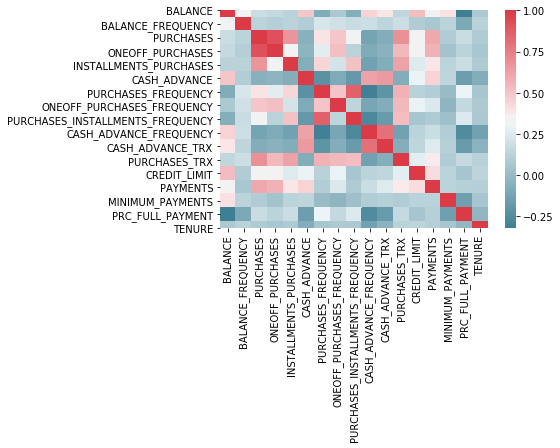

In [7]:
sns.heatmap(raw_data.corr(), cmap=sns.diverging_palette(220, 10, as_cmap=True))

From the table above and as confirmed by the graph above, you will see that utmost 4 features are relevant in prediciting another feature. An example is seen with `CASH_ADVANCE`, `INSTALLMENTS_PURCHASES`, `ONE-OFF_PURCHASES` and `PURCHASES` being relevant in predicting `PAYMENTS`

From an early observation, we cannot use all the feautures in our solution to the problem. We will have to carry further analysis in selecting important features for clusteting. 

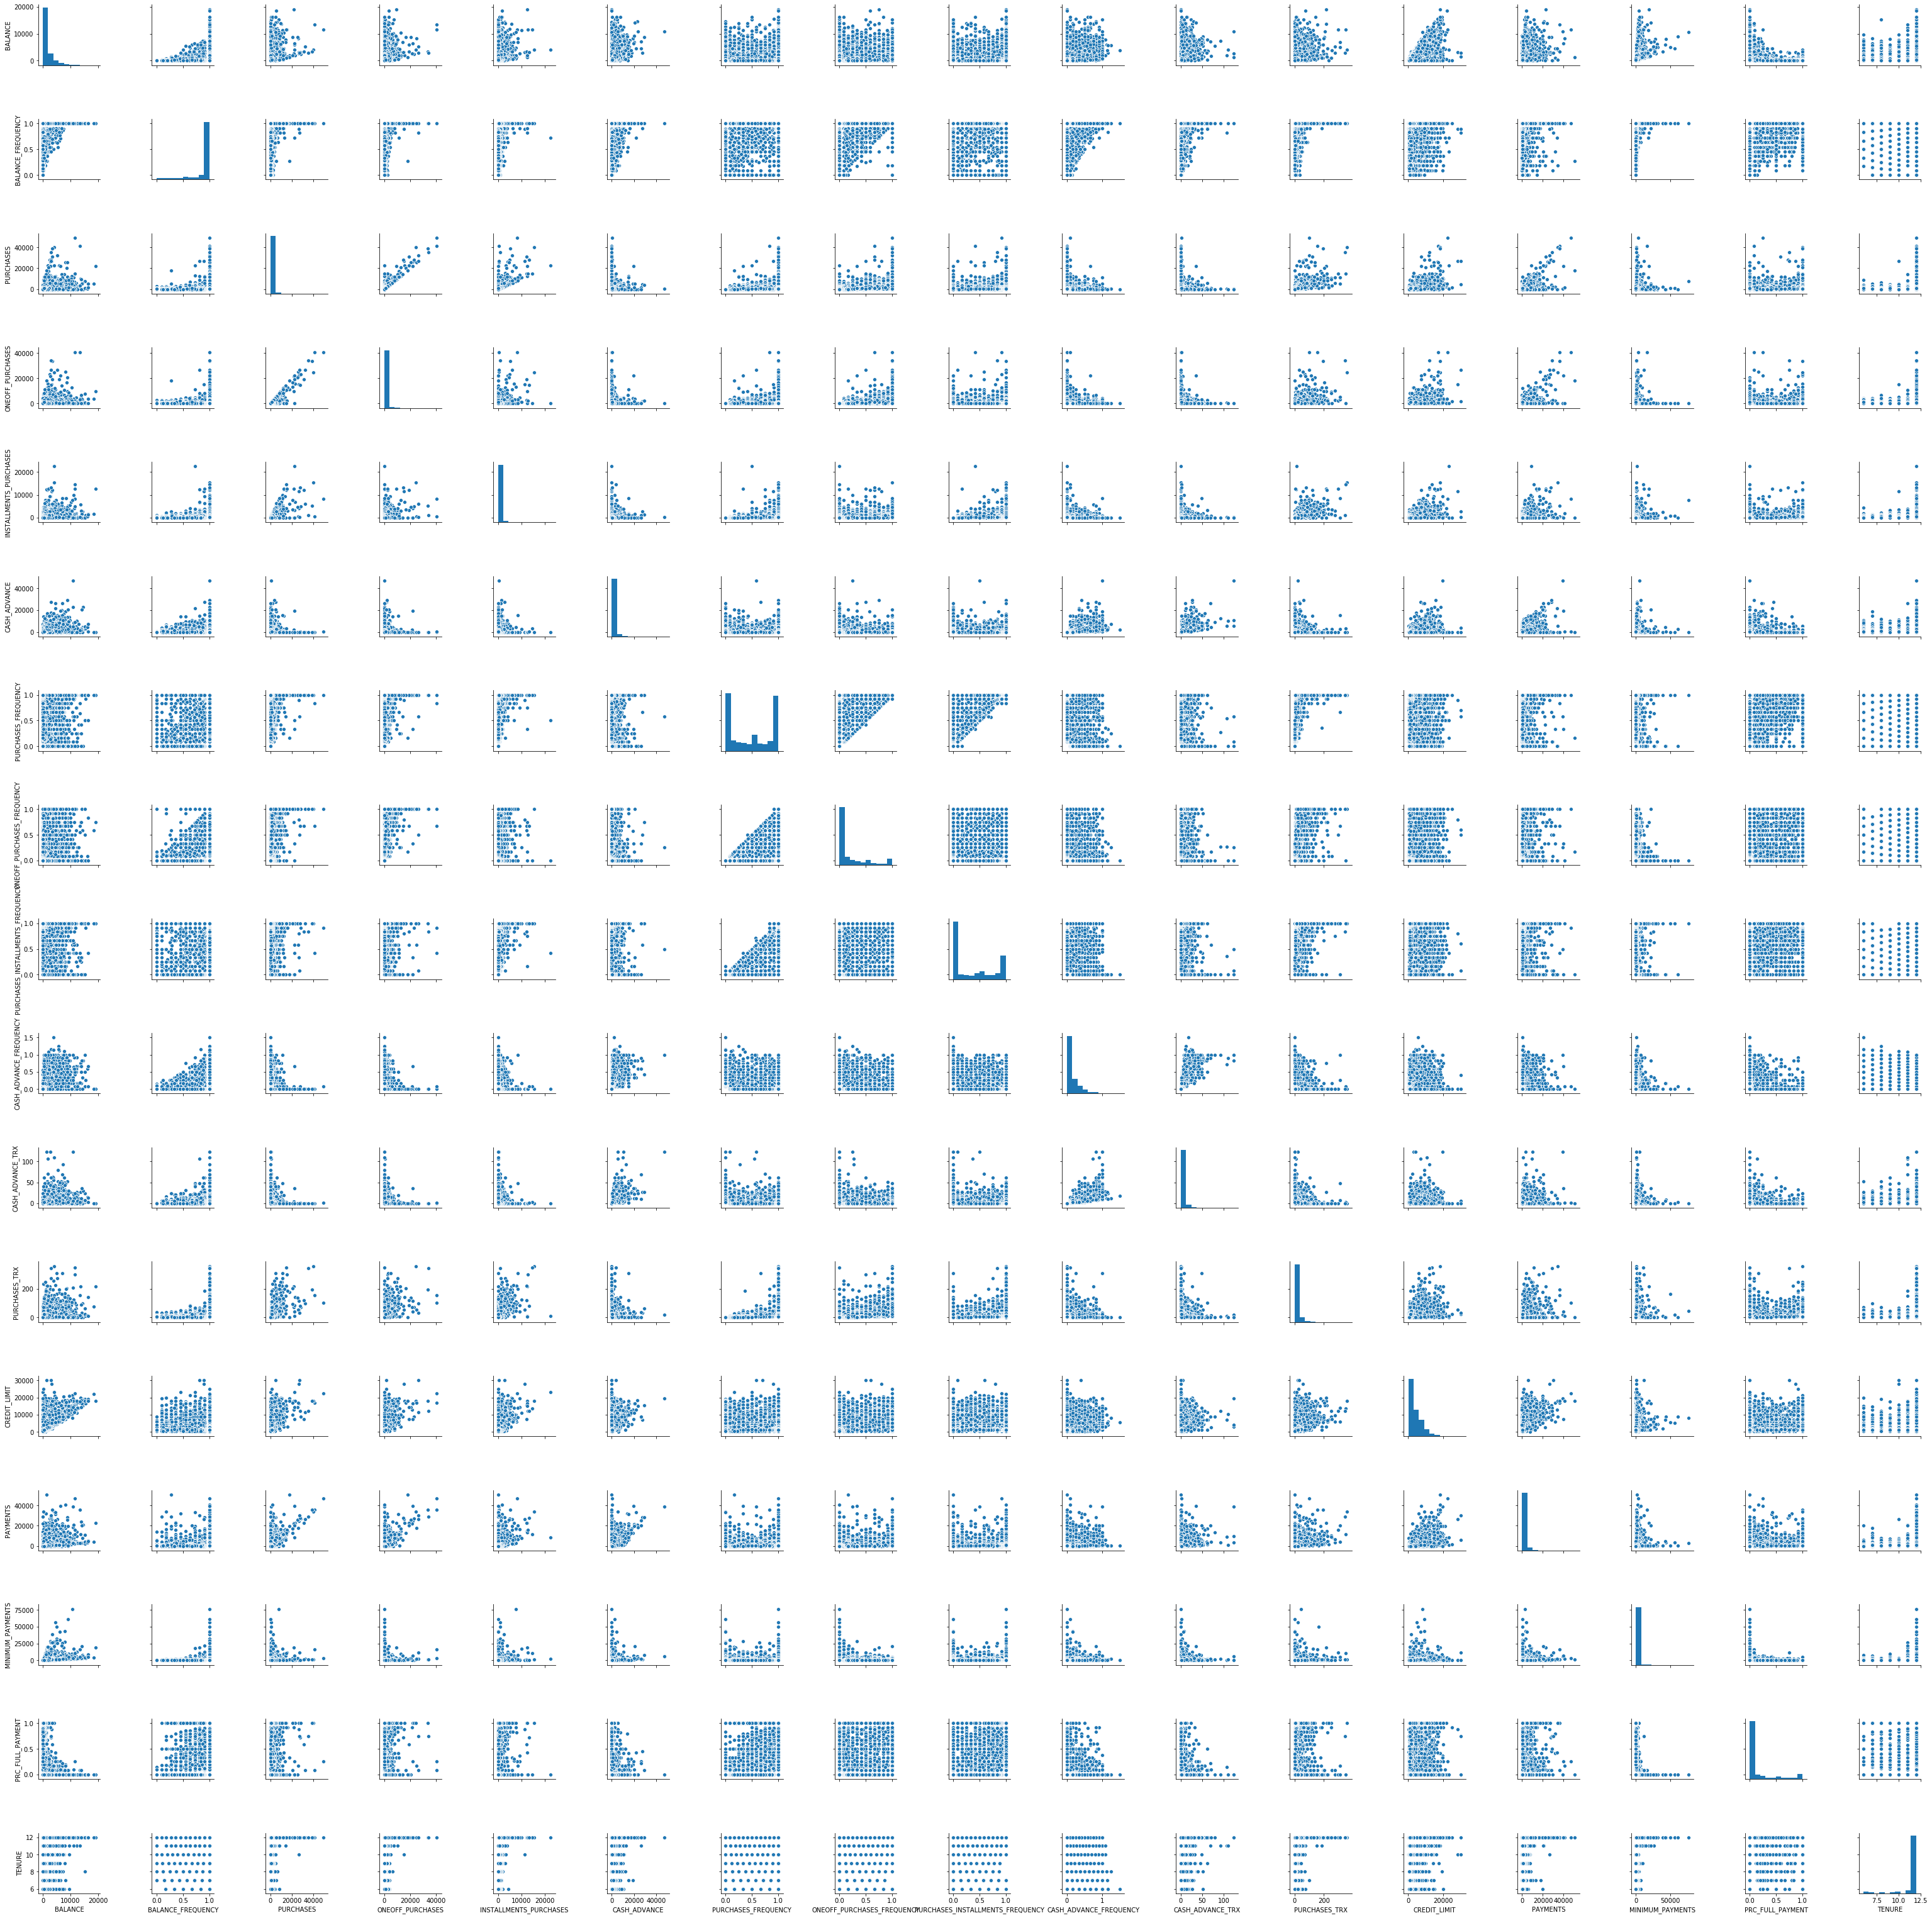

In [8]:
g = sns.pairplot(raw_data)

Concentration of data points around the origin i.e point-zero shows that the pair-feature are not correlated.

Furthermore, graphs showing evenly distributed data points all over the plot area show non-correlation between the pairs. A good example is paring `PRC_FULL_PAYMENT` with either `PURCHASES_FREQUENCY`, `ONEOFF_PURCHASES_FREQUENCY`, `PURCHASES_INSTALLMENTS_FREQUENCY`, `CASH_ADVANCE_FREQUENCY` or `TENURE`

Good examples of correlation is pairing `PURCHASES` with either `BALANCE`, `BALANCE_FREQUENCY`, `ONEOFF_PURCHASES`, `INSTALLMENTS_PURCHASES`, `PURCHASES_TRX`, `CREDIT_LIMIT` or `PAYMENTS`. You will also see that `PURCHASES` can be easily predicted by other features. The features that correlate well with `PURCHASES` have high score in feature importance.

# Data Preprocessing

The correlation above needs to be refined. A better way to do this is to scale the data and remove outliers. This will ensure that our results are significant and meaningful.

Since data is not normally distributed, i.e the mean and median vary significantly (indicating a large skew), we will apply a non-linear scaling using [Yeo-Johnson](https://academic.oup.com/biomet/article-abstract/87/4/954/232908)[1] (I.K. Yeo and R.A. Johnson, 2000) transformation that reduces skewness.

I would have used [Box-Cox](https://www.jstor.org/stable/2984418) [2] transformation but our data that has zeros. Yeo-Johnson transformation is able to transform data that zeros and negative numbers.

[1] Yeo and R.A. Johnson, “A new family of power transformations to improve normality or symmetry.” Biometrika, 87(4), pp.954-959, (2000)

[2] G.E.P. Box and D.R. Cox, “An Analysis of Transformations”, Journal of the Royal Statistical Society B, 26, 211-252 (1964)

--

In [8]:
pt = PowerTransformer(method="yeo-johnson", standardize=True)
scaled_data_ndarray = pt.fit_transform(raw_data_without_id)
scaled_data = pd.DataFrame.from_records(scaled_data_ndarray, columns=raw_data_without_id.columns)
# scaled_data = np.log(raw_data_without_id)
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(raw_data_without_id.values)
# scaled_data = pd.DataFrame(scaled_features, index=raw_data_without_id.index, columns=raw_data_without_id.columns)



In [9]:
scaled_data.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count  8.950000e+03       8.950000e+03  8.950000e+03      8.950000e+03   
mean  -5.080976e-17      -4.826927e-16  1.238488e-16      6.986342e-17   
std    1.000056e+00       1.000056e+00  1.000056e+00      1.000056e+00   
min   -2.120305e+00      -1.997716e+00 -1.505149e+00     -1.000488e+00   
25%   -8.168070e-01      -5.989922e-01 -6.547989e-01     -1.000488e+00   
50%    1.516813e-01       6.286119e-01  1.607696e-01      2.375163e-01   
75%    7.179130e-01       6.286119e-01  7.102506e-01      9.909450e-01   
max    2.731227e+00       6.286119e-01  3.559070e+00      1.959134e+00   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count            8.950000e+03  8.950000e+03         8.950000e+03   
mean             6.867257e-17  1.365512e-16         6.668781e-17   
std              1.000056e+00  1.000056e+00         1.000056e+00   
min             -1.085422e+00 -9.445384e-01        -1.278866e+00   
25%             -1.085422e+00 -9.445384e-01        -1.015926e+00   
50%              3.611963e-01 -9.445384e-01         1.196567e-01   
75%              9.060999e-01  1.059052e+00         1.050283e+00   
max              2.212015e+00  1.729923e+00         1.218860e+00   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                8.950000e+03                      8.950000e+03   
mean                -3.810732e-17                     -7.621464e-17   
std                  1.000056e+00                      1.000056e+00   
min                 -9.033151e-01                     -1.004445e+00   
25%                 -9.033151e-01                     -1.004445e+00   
50%                 -9.222973e-02                     -2.738452e-01   
75%                  9.780771e-01                      1.069884e+00   
max                  1.732554e+00                      1.377136e+00   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count            8.950000e+03      8.950000e+03   8.950000e+03  8.949000e+03   
mean            -9.804696e-17     -1.254366e-16  -2.858049e-16 -1.537167e-15   
std              1.000056e+00      1.000056e+00   1.000056e+00  1.000056e+00   
min             -8.832040e-01     -9.058009e-01  -1.387624e+00 -4.572732e+00   
25%             -8.832040e-01     -9.058009e-01  -8.727179e-01 -8.805581e-01   
50%             -8.832040e-01     -9.058009e-01   1.432569e-01 -1.296753e-01   
75%              1.016910e+00      1.044342e+00   7.291175e-01  8.300226e-01   
max              1.902718e+00      1.921254e+00   2.838620e+00  2.851692e+00   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT        TENURE  
count  8.950000e+03      8.637000e+03      8.950000e+03  8.950000e+03  
mean  -6.351220e-17      2.632554e-16     -6.986342e-17  7.621464e-16  
std    1.000056e+00      1.000058e+00      1.000056e+00  1.000056e+00  
min   -2.782085e+00     -5.725828e+00     -6.778889e-01 -2.526612e+00  
25%   -6.089046e-01     -6.464384e-01     -6.778889e-01  4.222524e-01  
50%   -6.428417e-02     -1.194703e-01     -6.778889e-01  4.222524e-01  
75%    5.694526e-01      6.861906e-01      8.541173e-01  4.222524e-01  
max    4.568553e+00      3.987426e+00      1.873638e+00  4.222524e-01

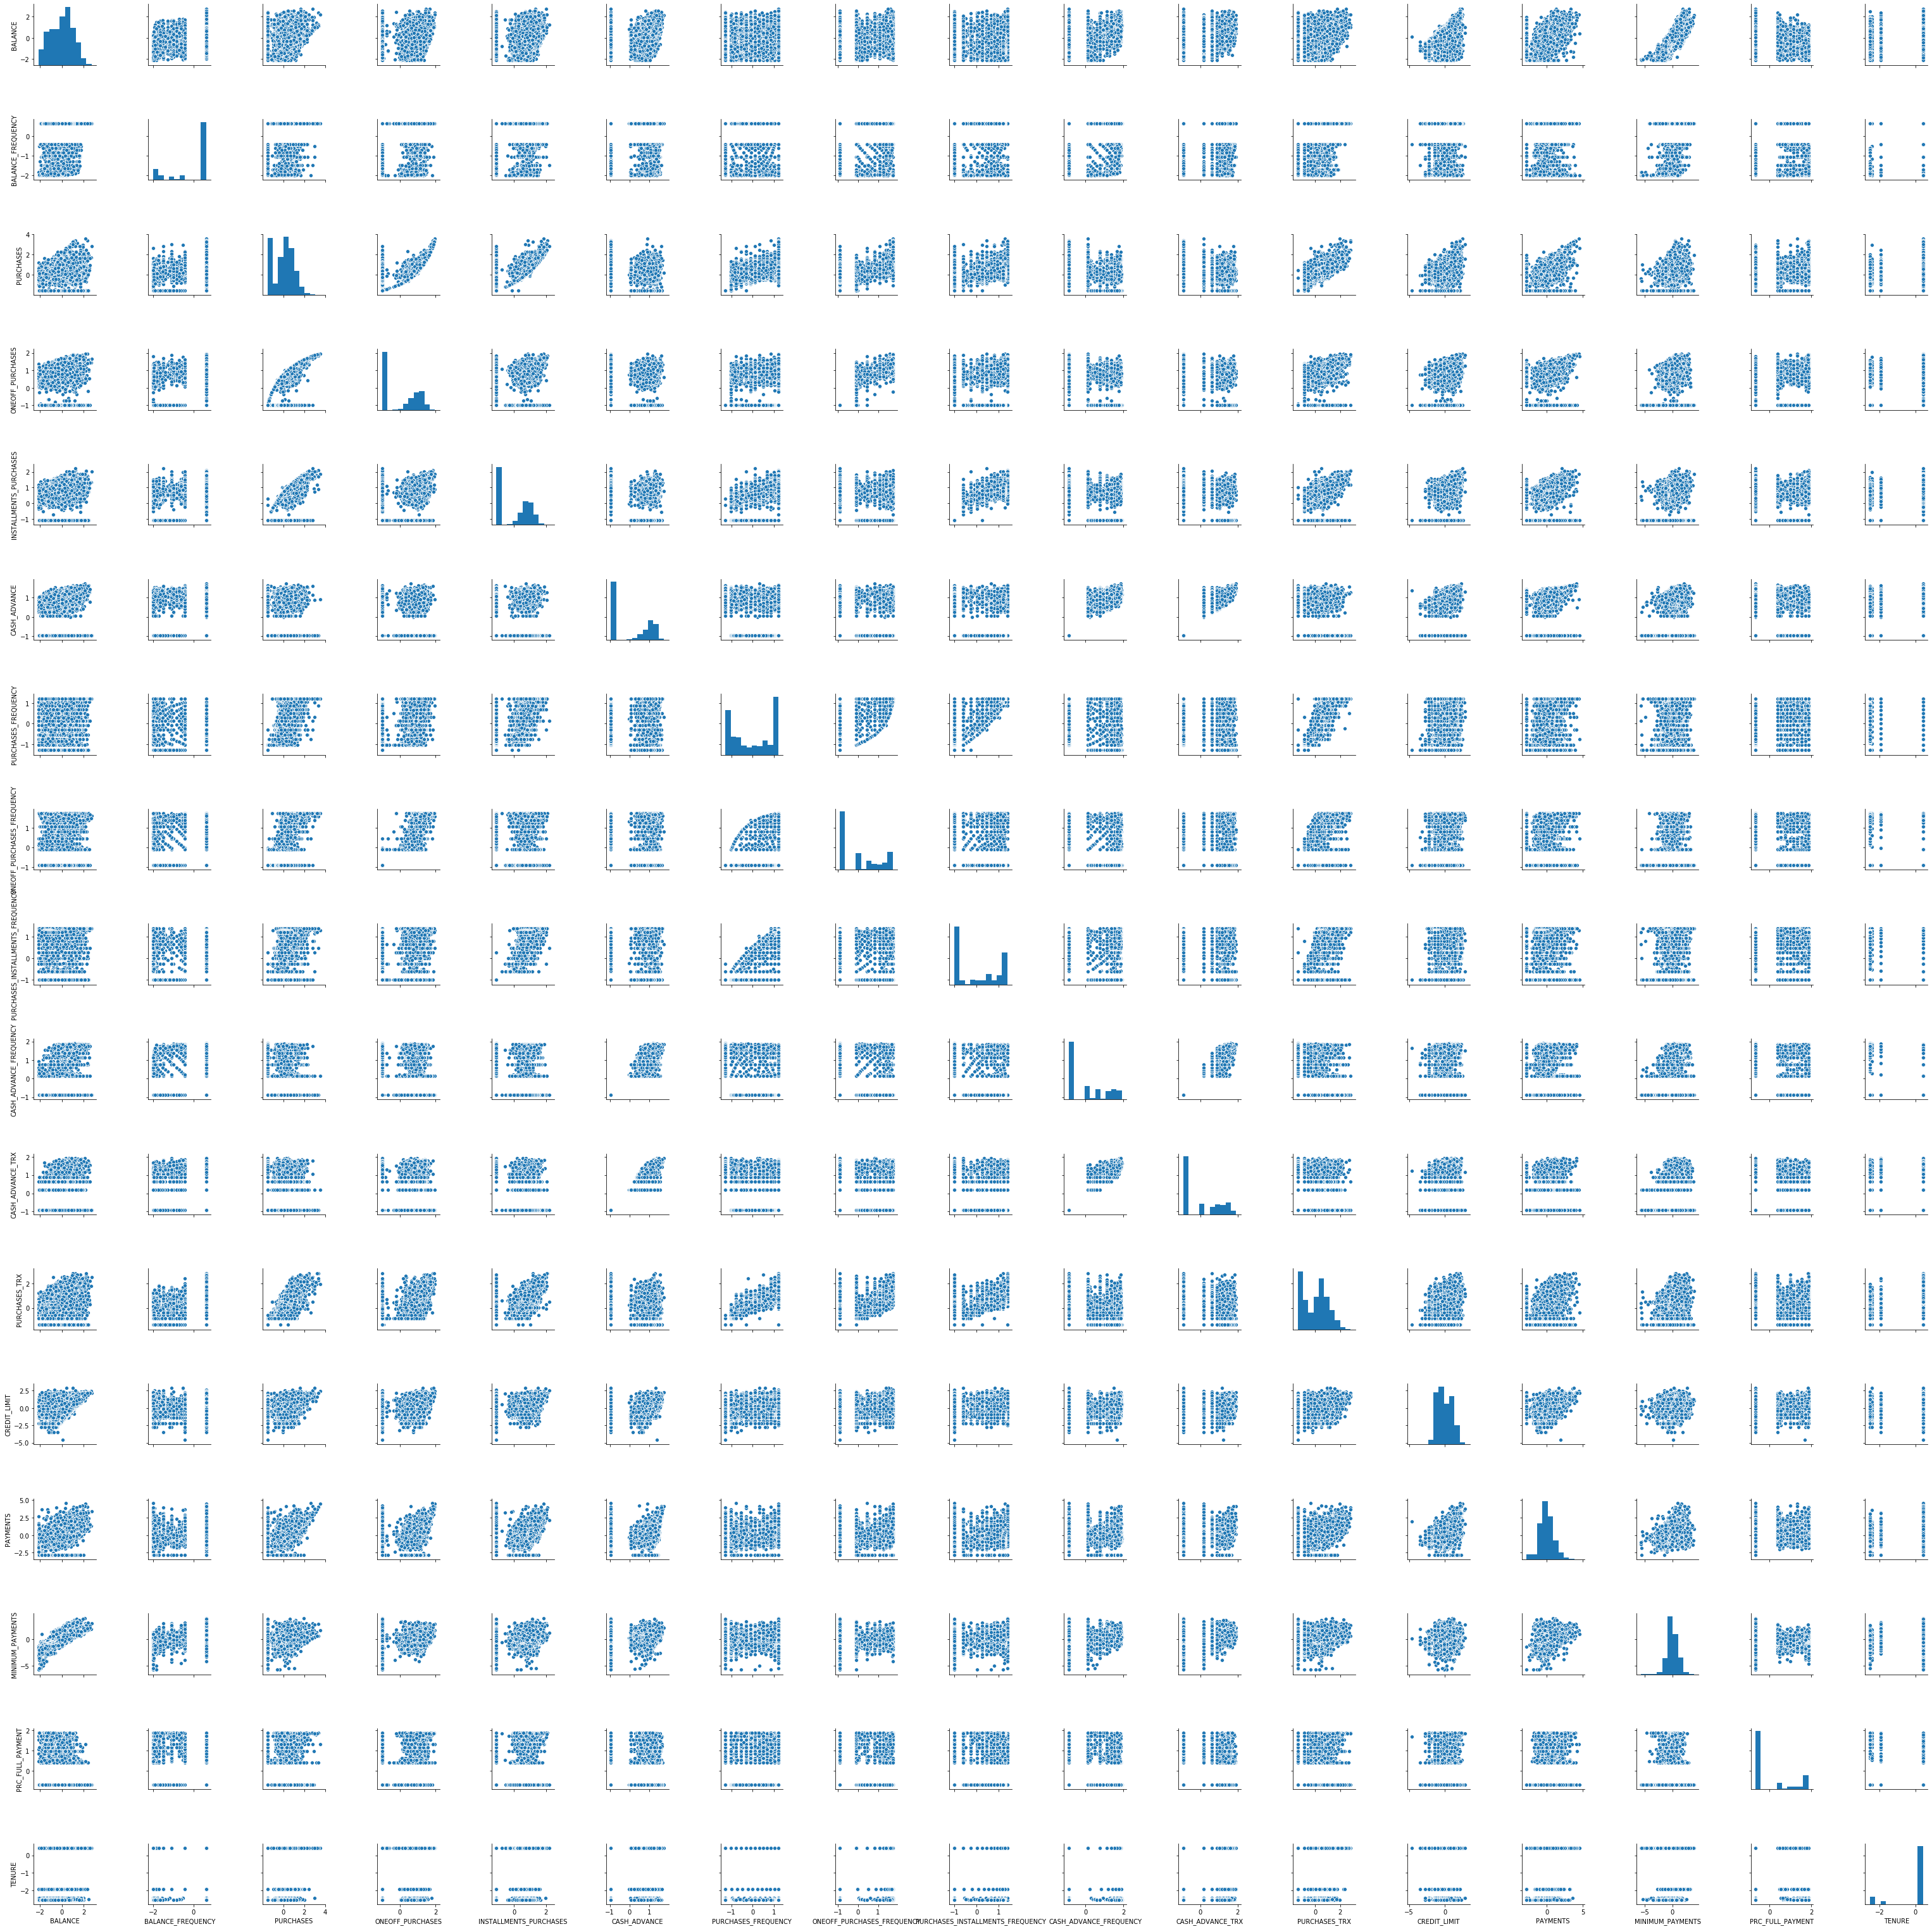

In [11]:
h = sns.pairplot(scaled_data)

In [10]:
# Lets view the scaled data of the samples
samples_scaled = pd.DataFrame(scaled_data.loc[sample_indices], columns = scaled_data.keys()).reset_index(drop = True)
# samples_scaled.insert(0, "CUST_ID", samples["CUST_ID"])
print("\nChosen samples transaction dataset:")
display(samples_scaled)


Chosen samples transaction dataset:


BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -1.889605          -1.990991  -0.596474          0.305773   
1  0.259170           0.628612   0.411114         -1.000488   
2 -1.331782           0.628612   0.320812          0.960165   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -1.085422     -0.944538            -1.015926   
1                0.998313     -0.944538             1.050283   
2               -1.085422     -0.944538             1.218860   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.092230                         -1.004445   
1                   -0.903315                          1.284999   
2                    1.732554                         -1.004445   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0               -0.883204         -0.905801      -0.872718     -0.956195   
1               -0.883204         -0.905801       0.436961     -0.809264   
2               -0.883204         -0.905801       0.494757      0.924151   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT    TENURE  
0 -0.768839         -1.240579         -0.677889  0.422252  
1 -0.982968         -0.268339         -0.677889  0.422252  
2 -0.459053         -0.532228          1.873638  0.422252

## Outliers detection and removal

This forms an integral part of data pre-processing. We remove data that tend to skew the distribution of data. The presence of the data points may lead to skewed results. K-Means clustering is very sensitive to outliers. Therefore, it is important we can remove the outliers from our data if we intend to use K-Means as our benchmark model.

In [11]:
outliers_, outliers_count_ = otl.detect(scaled_data)

print("Rows that are outliers: ", len(outliers_), "\n")

print("Feature rows that are outliers:\n")
for feat, count in outliers_count_.items():
    print("\t{}: {}".format(feat, count))

Rows that are outliers:  1694 

Feature rows that are outliers:

	PURCHASES: 20
	CREDIT_LIMIT: 8950
	PAYMENTS: 402
	MINIMUM_PAYMENTS: 8950
	TENURE: 1366


In [12]:
# Check if our samples are among the outliers
for index in sample_indices:
    if index in outliers_:
        print("Index {} is an outlier".format(index))

In [13]:
# Remove outliers from our data
good_data = scaled_data.drop(scaled_data.index[outliers_]).reset_index(drop = True)
good_data.dropna(inplace=True)

# I think we can disregard `CREDIT_LIMIT` and `MINIMUM_PAYMENTS` since their data points seem unrelated
good_data.drop(['CREDIT_LIMIT', 'MINIMUM_PAYMENTS'], axis=1, inplace=True)

# Feature Transformation

We are going to transform our data into few dimensions that maximize variance. We will do this by implementing PCA

--

## PCA

Principal Component Analysis (PCA) is a method used in dimensionality reduction. Many variables are reduced into few while containing much information in them.

Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process (Zakaria Jaadi). [1]

[1] Zakaria Jaadi. A step by step explanation of Principal Component Analysis. Feb 28, 2019. [https://towardsdatascience.com/a-step-by-step-explanation-of-principal-component-analysis-b836fb9c97e2] Accessed on Aug 1, 2019.

In [14]:
pca = PCA(n_components=good_data.shape[1])
pca.fit(good_data)

# Transform samples data using the PCA fit above
samples_scaled_2 = samples_scaled.drop(['CREDIT_LIMIT', 'MINIMUM_PAYMENTS'], axis=1)
pca_samples = pca.transform(samples_scaled_2)

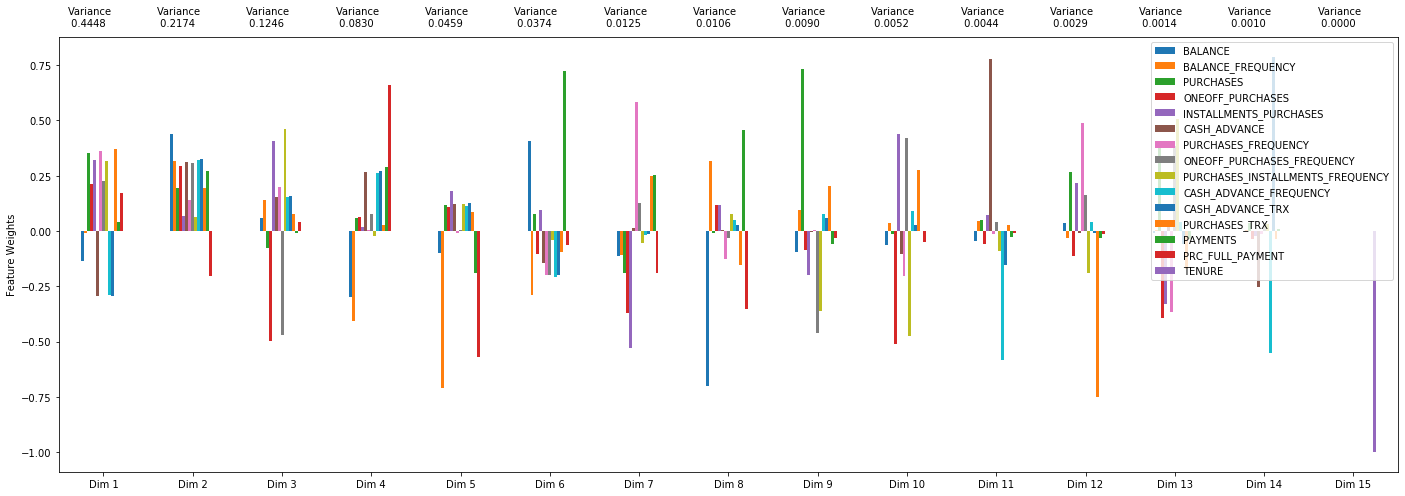

In [15]:
# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

From the above graph, we can easily pick the first 2 dimensions to represent the features.

The total variance covered by the two dimensions is about 65%. This is further shown by the figure below.

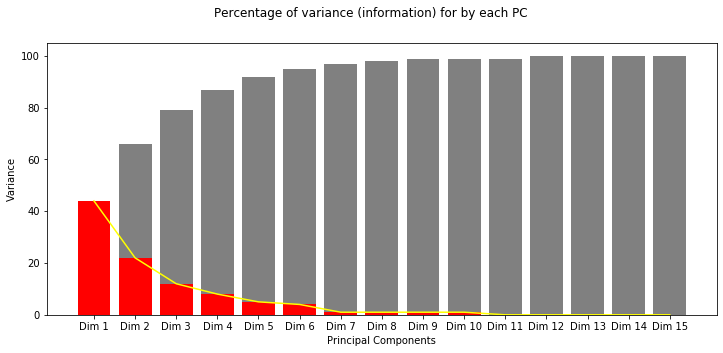

In [16]:
vs.pc_variance(pca_results)

### Observation

Lets see how our sample data will look like after PCA transformation.

In [17]:
# Display sample data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

Dim 1   Dim 2   Dim 3   Dim 4   Dim 5   Dim 6   Dim 7   Dim 8   Dim 9  \
0 -0.7481 -3.0080 -2.0776 -0.0186  1.4975 -0.0981  0.1806  0.5785 -0.0839   
1  1.4554 -0.8907  1.7856 -1.8400  0.1839 -0.1907  0.0948 -0.3831  0.2306   
2  1.7958 -0.8501 -2.2932  0.8108 -1.6493 -1.5002  0.8916 -0.2277  0.0696   

   Dim 10  Dim 11  Dim 12  Dim 13  Dim 14  Dim 15  
0 -0.1474 -0.1011 -0.0671 -0.0060 -0.0041     0.0  
1 -0.1091 -0.0373  0.2638  0.1043  0.0110     0.0  
2  0.1296  0.0401  0.3610 -0.2378 -0.0053     0.0

### Dimensionality Reduction

With 65% cumulative variance we are confident in using 2 dimensions in reducin the feature space. Therefore, we will generate 2 principal components from our data. We will also transform our sample data using the fitter PCA.

In [18]:
n_components=2
pca = PCA(n_components=n_components)
pca.fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform sample data using the PCA fit above
pca_samples2 = pca.transform(samples_scaled_2)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ["Dimension {}".format(x + 1) for x in range(n_components)])

In [19]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples2, 6), columns = ["Dimension {}".format(x + 1) for x in range(n_components)]))

Dimension 1  Dimension 2
0    -0.748140    -3.007958
1     1.455358    -0.890707
2     1.795834    -0.850108

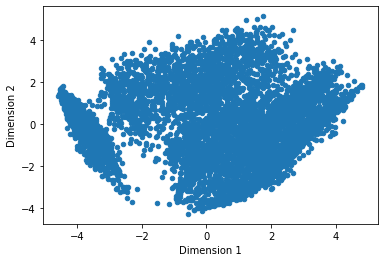

In [20]:
# Visualize reduced data
reduced_data.plot.scatter(x="Dimension 1", y="Dimension 2")

The plot above indicates that we can seperate our data into 3 clusters.

Let visualize the data using a biplot. The biplot will project original features over the components.

From the biplot you will notice that there is one cluster that spends more while another is liquid in terms of cash and balance. The cluster on the bottom-right does alot of purchasing as evidenced by huge variance in purchase related features. The cluster in the top maintains good balance in the card, pays the card issuer regularly and purchase with cash oftenly.

There is a cluster on the left that has similarities with the top one. However, for this cluster, it seems they use cash alot with less payments back to the issuer. And also seems to not be purchasing or using the credit card.

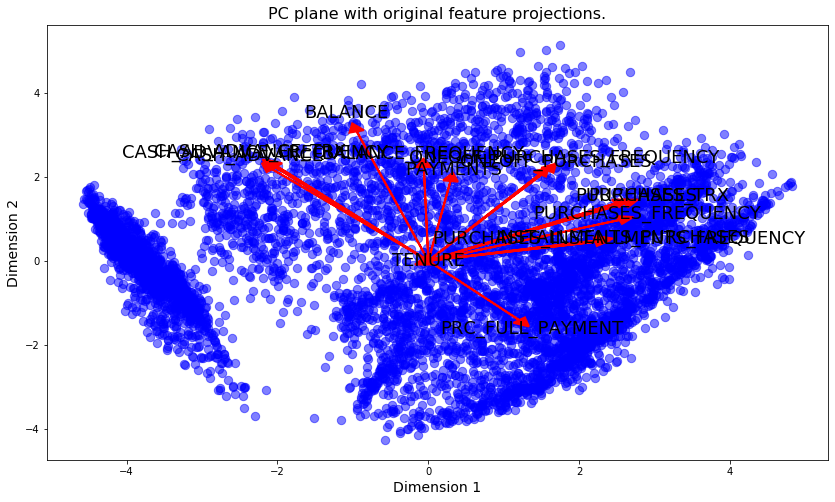

In [21]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

## Clustering

We will try and use the above insights in creating clusters that would give us accpetable score. Note that, we already biased that our data can be grouped into 3 clusters.

We will use K-Means with 3 clusters as our **benchmark model**.


In [22]:
# benchmark model
N_CLUSTER_TRIALS = range(2, 6)

def get_cluster_and_score(n_clusters):
    kmeans = cluster.KMeans(n_clusters=n_clusters)
    kmeans.fit(reduced_data)
    pred = kmeans.predict(reduced_data)
    score = silhouette_score(
        reduced_data, pred)
    return score

trials = {x: get_cluster_and_score(x) for x in N_CLUSTER_TRIALS}

display(pd.DataFrame(
    data={"Cluster {}".format(x): [y] for x,y in trials.items()},
    index=["Scores"]
))

Cluster 2  Cluster 3  Cluster 4  Cluster 5
Scores    0.47283    0.45217   0.469311   0.435076

Lets look for another alogrithms that may perform better than our benchmark model and also curve out our clusters closely.

How an algorithm can scale is an important consideration.

We will carry out hard clustering since we are already interested in getting 3 clusters.

In [24]:
def get_cluster_and_score_cls(clf: tuple) -> list:
    result = []
    for algorithm in clf:
        algorithm.fit(reduced_data)
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
        score = silhouette_score(reduced_data, y_pred)
        result.append(score)
    return result

def get_clfs(n_clusters: int) -> dict:
    return (
        cluster.KMeans(n_clusters),
        cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage="average", affinity="euclidean"),
        cluster.SpectralClustering(n_clusters=n_clusters)
    )

ctrials = {x: get_cluster_and_score_cls(get_clfs(x)) for x in N_CLUSTER_TRIALS}

display(pd.DataFrame(
    data={"Cluster {}".format(x): y for x,y in ctrials.items()},
    index=["K-Means", "AgglomerativeClustering", "SpectralClustering"]
))

Cluster 2  Cluster 3  Cluster 4  Cluster 5
K-Means                   0.472867   0.452157   0.469293   0.435183
AgglomerativeClustering   0.471861   0.444634   0.446531   0.410976
SpectralClustering        0.472952   0.453267   0.458003   0.435884

From our observation, we need 3 clusters. Therefore, from the scores above we can easily choose **SpectralClustering** as our algorithm of choice.

We need to optimize it such that it can fit our clusters properly.

## Cluster Visualization

We will need to optimize `gamma` parameter of **SpectralClustering** algorithm in order to fit our clusters.



Score:  0.4362551951270647


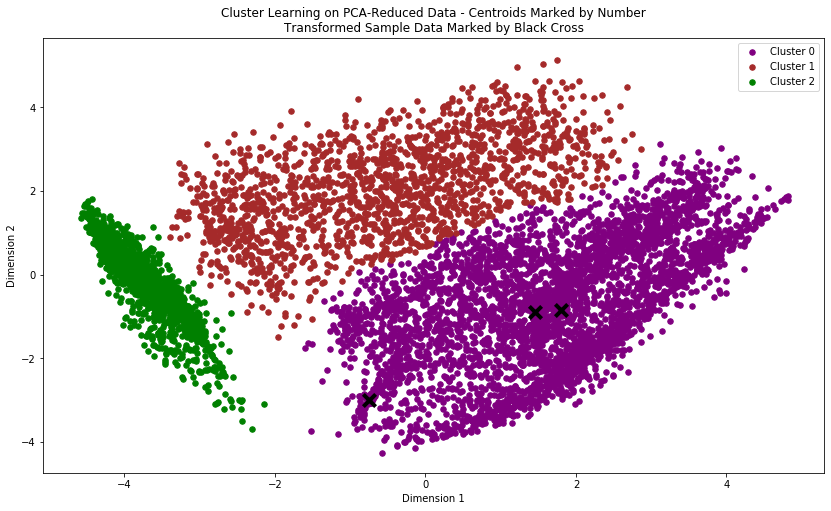

In [27]:
# Display the results of the clustering from implementation
alg = cluster.SpectralClustering(n_clusters=3, gamma=50)
cluster_labels = alg.fit_predict(reduced_data)
y_pred = alg.labels_
print("Score: ", silhouette_score(reduced_data, y_pred))
try:
    centers = alg.cluster_centers_
    vs.cluster_results(reduced_data, y_pred, pca_samples2, centers)
except AttributeError:
    vs.cluster_results(reduced_data, y_pred, pca_samples2)

Lets look at the cluster scores using different distance metrics [1]

[1] Pairwise Distance Metrics - https://www.mathworks.com/help/stats/classification-using-nearest-neighbors.html#bsfjytu-1
    
    

In [45]:
from sklearn.metrics import pairwise

distance_metrics = pairwise._VALID_METRICS[::]
try:
    distance_metrics.remove("minkowski")
    distance_metrics.remove("wminkowski")
except ValueError:
    pass
scores_ = {m: silhouette_score(reduced_data, y_pred, metric=m) for m in distance_metrics}

In [50]:
scores_df = pd.DataFrame(index=["Scores"], data=dict(sorted(scores_.items(), key=lambda kv: kv[1], reverse=True)))
display(scores_df)

sqeuclidean    cosine  correlation  braycurtis  chebyshev  euclidean  \
Scores     0.575645  0.525399     0.513026    0.463203   0.441026   0.436255   

              l2        l1  manhattan  cityblock  ...  hamming  jaccard  \
Scores  0.436255  0.424727   0.424727   0.424727  ...      0.0      0.0   

        kulsinski  matching  rogerstanimoto  russellrao  sokalmichener  \
Scores        0.0       0.0             0.0         0.0            0.0   

        sokalsneath  yule  haversine  
Scores          0.0   0.0  -0.011491  

[1 rows x 24 columns]